In [1]:
import xarray as xr
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar
import numpy as np
import glob
import os
import gsw
import matplotlib.pyplot as plt

In [18]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(queue='stage7', cores=4, project='gfdl_o',
                       memory="192GB", walltime="01:00:00",
                       scheduler_options={"dashboard_address": f":{8726}"})

In [19]:
cluster.scale(1)

In [20]:
client = Client(cluster)
client

Client Scheduler: tcp://140.208.147.171:38869 Dashboard: http://140.208.147.171:8726/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [21]:
def open_frompp(pp,ppname,out,local,time,var,get_static=True):
    _,paths = get_pathspp(pp,ppname,out,local,time,var,get_static=get_static)
    return xr.open_mfdataset(paths,use_cftime=True)

def get_pathspp(pp,ppname,out,local,time,var,get_static=True):
    filename = ".".join([ppname,time,var,'nc'])
    path = "/".join([pp,ppname,out,local,filename])
    paths = glob.glob(path)
    if get_static:
        static = ".".join([ppname,'static','nc'])
        paths.append("/".join([pp,ppname,static]))
    return path,paths

def get_pathstatic(pp,ppname):
    static = ".".join([ppname,'static','nc'])
    path = "/".join([pp,ppname,static])
    return path

def issue_dmget(paths,wait=True):
    cmd = "dmget "+' '.join(paths)
    if not wait:
        cmd += " &"
    os.system(cmd)

In [109]:
def create_path(pp,ppname,out,local,time,var):
    filename = create_filename(ppname,time,var)
    return "/".join([pp,ppname,out,local,filename])

def create_filename(ppname,time,var):
    return ".".join([ppname,time,var,'nc'])

In [129]:
pathDict = {'pp':('../../data/raw/ESM4/ESM4_piControl_D/'+
                  'gfdl.ncrc4-intel16-prod-openmp/pp'),
           'ppname':'ocean_cobalt_omip_tracers_month_z',
           'out':'av',
           'local':'monthly_5yr',
           'time':['1','2'],#['0{}*'.format(i) for i in range(28,34)],
           'var':['thetao','so'],
           }

path = []
if all(isinstance(value,str) for value in pathDict.values()):
    path = create_path(pathDict['pp'],
                      pathDict['ppname'],
                      pathDict['out'],
                      pathDict['local'],
                      pathDict['time'],
                      pathDict['var'],
                      )
else:
    listkeys = [key for key in pathDict if isinstance(pathDict[key],list)]
    listvalues=[]
    for key in listkeys:
        listvalues.append(pathDict[key])
        
        # Create super list of all paths that need to be looped over 
#         = for value in pathDict[key]:
#             print(value)
#     for key,item in pathDict.items():
#         if isinstance(item,str):
#             for p in range(len(paths)):
#                 paths[p]+=item
#     for key in keys:
#         for value in pathDict[key]:
#             path.append(create_path(pathDict['pp'],
#                           pathDict['ppname'],
#                           pathDict['out'],
#                           pathDict['local'],
#                           pathDict['time'],
#                           pathDict['var'],
#                           ))
        

# def get_pathspp(pathDict,get_static=True):
# paths=['']
# for key,item in pathDict.items():
#     if isinstance(item,str):
#         for p in range(len(paths)):
#             paths[p]+=item
#     if isinstance(item,list):
#         # expand from list to bracket expansion
#         newitem='{'
#         for i in item:
#             newitem+=i+','
#         newitem = newitem[:-1]+'}'
#         item = newitem
#     exec(key+"='"+item+"'")

# paths


# paths = glob.glob(path)
# if get_static:
#     static = ".".join([ppname,'static','nc'])
#     paths.append("/".join([pp,ppname,static]))
#     return path,paths

In [130]:
listvalues

[['1', '2'], ['thetao', 'so']]

In [88]:
pp = ('../../data/raw/ESM4/ESM4_piControl_D/'+
      'gfdl.ncrc4-intel16-prod-openmp/pp')
out = 'av'
local = 'monthly_5yr'
time = '0[23]*'
var = '*'

ppname = 'ocean_cobalt_omip_tracers_month_z'
path,paths = get_pathspp(pp,ppname,out,local,time,var,get_static=False)
# dsbio = xr.open_mfdataset(paths,use_cftime=True)

ppname = 'ocean_monthly_z'
path,paths = get_pathspp(pp,ppname,out,local,time,var,get_static=False)
# dsphy = xr.open_mfdataset(paths,use_cftime=True)

# grid = xr.open_dataset(get_pathstatic(pp,ppname))

In [11]:
dsphy['sigma2'] = gsw.sigma2(dsphy['so'],dsphy['thetao'])
bins = np.arange(20,30,0.1)
volume = histogram(dsphy['sigma2'],bins=[bins],weights=dsphy['volcello'],dim=['xh','yh','z_l'])
dissic = histogram(dsphy['sigma2'],bins=[bins],weights=dsbio['volcello']*dsbio['dissic'],dim=['xh','yh','z_l'])

In [12]:
volume = volume.load()

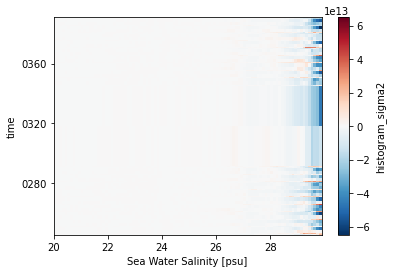

In [14]:
(volume-volume.mean('time')).plot()

In [ ]:
# client.close()
# cluster.close()